## Below the steps to identify the most promising stocks using the EPS X appraoch

1. have an excel file with all the tickers extracted from a filter on tradingview
2. Compute the FP (see below) for all the companies
3. Compute PFV (see below) for the all the companies
4. Create a flag column "below eps_pfv" indicating whether the price is below pfv
5. take the tickers respecting the condition 4 and create history plots
6. select by hand the most promising stocks
7. for the selected ones get the price to pfv ratio
8. do an ascending sort of the stocks with the values computed in 7 and see the most promising tickers

### Formula

* $FP = EPS \cdot (1 + Growth)^{Years} \cdot PE$

* $PFV = \frac{FP}{(1 + Return)^{Years}}$

In the equations : 

* `FP` means *Future Price* and refers to the price that the stock should have in the future
* `PFV` mean *Present Fair Value* and refers to the price that the company should be trading today in the market
* `EPS` refers to the EPS that we see of the company today (now, avg TTM, MRQ, etc)
* `Growth` refers to what I think the company is going to grow in the following years
* `Years` are the number of years to take into consideration when doing the calculation
* `PE` refers to what I think is going to be the PE ratio after all the years considered. Thus, this is an estimated future PE ratio
* `Return` refers to what I think is going to be the avg yearly return of the investment during all the years considered

### Imports

In [1]:
import certifi
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from urllib.request import urlopen
from datetime import timedelta
from typing import List, Any, Tuple, Dict

### Constants

In [2]:
current_assets_factors = {
    "receivables_factor": 0.8,
    "inventory_factor": 0.6,
    "ppe_factor": 0.67,
}

bs_cols = [
    "fillingDate",
    "symbol",
    "totalEquity",
    "totalCurrentAssets",
    "totalAssets",
    "totalCurrentLiabilities", 
    "totalLiabilities",
    "totalStockholdersEquity",
    "totalDebt",
    "goodwillAndIntangibleAssets",
    "goodwill",
    "intangibleAssets",
]
is_cols = [
    "fillingDate",
    "eps",
    "weightedAverageShsOutDil",
    
]

### Functions

In [3]:
def compute_fp(
    eps:float,
    growth_value: float,
    years: int,
    future_pe: float,
) -> float:
    capped_growth_value = min(0.40, growth_value)
    capped_future_pe = min(20, future_pe)
    return eps * ((1 + capped_growth_value) ** years) * capped_future_pe

def compute_pfv(fp: float, return_value: float, years: int) -> float:
    capped_return_value = min(0.20, return_value)
    return fp / ((1 + capped_return_value) ** years)

def compute_pex_value_handler(
    eps: float,
    growth_value: float,
    return_value: float,
    future_pe: float,
    years: int,
) -> float:
    fp = compute_fp(eps, growth_value, years, future_pe)
    pfv = compute_pfv(fp, return_value, years)
    return pfv

In [4]:
def get_income_stmt_info(ticker: str, nb_years: int = 10) -> List[Dict[str, Any]]:
    url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit={nb_years}&apikey={KEY}"
    response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
    data_income_stmt = response_income_stmt.read().decode("utf-8")
    data_income_stmt = json.loads(data_income_stmt)
    return data_income_stmt

def get_key_from_iterator(iterator: List[Dict[str, Any]], key: str) -> List[float]:
    all_eps = [element[key] for element in iterator]
    return all_eps

def compute_historical_growth(iterator: List[float]) -> List[float]:
    all_growth = [np.nan]
    for idx in range(1, len(iterator)):
        all_growth.append((iterator[idx] - iterator[idx-1]) / iterator[idx-1])
    return all_growth

def drop_nans(iterator: List[float]) -> List[float]:
    iterator_wo_nans = [element for element in iterator if not np.isnan(element)]
    return iterator_wo_nans

def compute_stat_bound(
    iterator: List[float], q_inf: float = 0.25, q_sup: float = 0.75, distance: int = 3
) -> Tuple[float, float]:
    q1 = np.quantile(iterator, q_inf)
    q3 = np.quantile(iterator, q_sup)
    iqr = q3 - q1
    lower_bound = q1 - distance*iqr
    upper_bound = q3 + distance*iqr
    return lower_bound, upper_bound

def compute_avg_value(iterator: List[float]) -> float:
    avg = np.mean(iterator)
    return avg

In [5]:
def get_reporting_window(financial_info: Dict[str, Any]) -> Tuple[str, str]:
    last_report_date = financial_info["date"]
    window_start = pd.to_datetime(last_report_date) + pd.DateOffset(days=30)
    window_start = str(window_start.date())
    window_end = pd.to_datetime(last_report_date) + pd.DateOffset(days=46)
    window_end = str(window_end.date())
    return window_start, window_end

def get_prices_in_range(ticker: str, window_start: str, window_end: str) -> List[Dict[str, Any]]:
    url_prices =  f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={window_start}&to={window_end}&apikey={KEY}"
    response_prices = urlopen(url_prices, cafile=certifi.where())
    data_prices = response_prices.read().decode("utf-8")
    data_prices = json.loads(data_prices)
    return data_prices

def handling_negative_pe(iterator: List[float]) -> List[float]:
    positive_historical_pe = [val if val > 0 else 0 for val in iterator]
    return positive_historical_pe

### Constants

In [6]:
KEY_PATH = "fmi-personal-key.txt"
with open(KEY_PATH, "r") as f:
    KEY = f.read()

In [7]:
with open("tickers_list_28062023.txt", "r") as f:
    TICKERS = f.read().split("\n")

In [8]:
TICKERS = list(set(TICKERS))

In [9]:
"CTHR" in TICKERS

True

Example of EPS X calculation for CTHR

There are 4 things that we need to decide to compute the value : 

* Return : I am going to use a standard of 20%
* Growth : I am going to use the data of the last 10 years and the what has been the avg growth. I am going to try it with EPS and then see if it's possible to do it with equity
* PE : The future PE ratio will be (10Y max - 10Ymin) / 2. I need to get the data from the last 10 years For the EPS it'll be straightforward, for the price I should match the eps of year X with the avg price of 3 months after the data of the report of year X
* Years : Number of years to consider in the calculations. I will use 7 (in between 5 and 10) cuz 5 is too short and 10 is too long

#### Return value

In [10]:
return_value = 0.2
return_value

0.2

#### Growth value

In [11]:
# steop by step

In [12]:
ticker = "CTHR"
url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=10&apikey={KEY}"
response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
data_income_stmt = response_income_stmt.read().decode("utf-8")
data_income_stmt = json.loads(data_income_stmt)

url_balance_sheet = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?limit=10&apikey={KEY}"
response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
data_balance_sheet = response_balance_sheet.read().decode("utf-8")
data_balance_sheet = json.loads(data_balance_sheet)

/var/folders/mr/pm_1h_jn1gs2n48rx1j1ygsr0000gn/T/ipykernel_59445/3274548525.py:3: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
/var/folders/mr/pm_1h_jn1gs2n48rx1j1ygsr0000gn/T/ipykernel_59445/3274548525.py:8: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())


In [9]:
all_eps = [element["eps"] for element in data_income_stmt]
all_eps

In [13]:
all_equity = [element["totalStockholdersEquity"] for element in data_balance_sheet]
all_equity

[59557767,
 55689016,
 41435577,
 45719024,
 34858626,
 34868621,
 38388777,
 46018173,
 57427673,
 56677176]

In [28]:
"""all_growth = []
for idx in range(1, len(all_eps)):
    all_growth.append((all_eps[idx] - all_eps[idx-1]) / all_eps[idx-1])"""

all_growth = []
for idx in range(1, len(all_equity)):
    all_growth.append((all_equity[idx-1] - all_equity[idx]) / all_equity[idx])

In [49]:
all_growth

[4.5,
 -1.5,
 -1.4545454545454546,
 -1.214,
 9.280373831775702,
 1.1363636363636362,
 0.38297872340425543,
 -0.9001538461538462,
 -4.543913713405239]

In [29]:
all_growth

[0.06947062954030289,
 0.343990358816531,
 -0.09369069208476541,
 0.31155553864917107,
 -0.00028664741287015626,
 -0.09169752920234994,
 -0.16579093655021898,
 -0.1986759937147375,
 0.013241608932668065]

In [ ]:
(0.343990358816531 - 0.31155553864917107) / 

In [30]:
# Cap the extreme growth rates for a more conservative approach
# Not the extrem drops since it'll help put numbers down
q1 = np.quantile(all_growth, 0.25)
q3 = np.quantile(all_growth, 0.75)
iqr = q3 - q1
lower_bound = q1 - 3*iqr
upper_bound = q3 + 3*iqr

all_growth_wo_extremes = [min(element, upper_bound) for element in all_growth]# if lower_bound < element < upper_bound]
all_growth_wo_extremes

[0.06947062954030289,
 0.343990358816531,
 -0.09369069208476541,
 0.31155553864917107,
 -0.00028664741287015626,
 -0.09169752920234994,
 -0.16579093655021898,
 -0.1986759937147375,
 0.013241608932668065]

In [31]:
lower_bound, upper_bound

(-0.5831746569599703, 0.5589545944155078)

In [32]:
growth_value = np.mean(all_growth_wo_extremes)#np.mean(all_growth)

In [53]:
growth_value

0.5906466949726956

In [33]:
growth_value

0.020901815219303448

In [35]:
growth_5y = (all_growth_wo_extremes[0] - all_growth_wo_extremes[4]) / 4
growth_10y = (all_growth_wo_extremes[0] - all_growth_wo_extremes[-1]) / 9
 
(growth_5y + growth_10y) / 2, growth_5y, growth_10y, (all_growth_wo_extremes[0] - all_growth_wo_extremes[-4]) / 6

(0.011843494097348566,
 0.017439319238293262,
 0.00624766895640387,
 0.02686135979044214)

In [38]:
growth_5y = (all_growth_wo_extremes[0] / all_growth_wo_extremes[4]) ** (1/4) - 1
growth_10y = (all_growth_wo_extremes[0] / all_growth_wo_extremes[-1]) ** (1/9) - 1

(growth_5y + growth_10y) / 2, growth_5y, growth_10y, (all_growth_wo_extremes[0] / all_growth_wo_extremes[-4]) ** (1/6)

((0.9960918112851872+1.3949810516068974j),
 (1.7899621032137953+2.789962103213795j),
 0.20222151935657906,
 (0.8268712624631954+0.4773943459682915j))

In [61]:
# using methods

In [60]:
ticker = "CTHR"
data_income_stmt = get_income_stmt_info(ticker=ticker, nb_years=10)
all_eps = get_key_from_iterator(iterator=data_income_stmt, key="eps")
all_growth = compute_historical_growth(all_eps)
all_growth = drop_nans(all_growth)
lower_bound, upper_bound = compute_stat_bound(all_growth, distance=3)
all_growth_wo_extremes = [min(element, upper_bound) for element in all_growth]
growth_value = compute_avg_value(all_growth_wo_extremes)
growth_value

/var/folders/mr/pm_1h_jn1gs2n48rx1j1ygsr0000gn/T/ipykernel_9088/3436755680.py:3: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())


0.5906466949726956

#### Future PE

In [16]:
# The reporting of a period is expected between 30 - 45 days after the ending of that period
all_prices = []
for single_income_stmt in data_income_stmt[::-1]:
    reporting_window_start = pd.to_datetime(single_income_stmt["date"]) + pd.DateOffset(days=30)
    reporting_window_start = str(reporting_window_start.date())
    reporting_window_end = pd.to_datetime(single_income_stmt["date"]) + pd.DateOffset(days=46)
    reporting_window_end = str(reporting_window_end.date())
    
    url_prices =  f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={reporting_window_start}&to={reporting_window_end}&apikey={KEY}"
    response_prices = urlopen(url_prices, cafile=certifi.where())
    data_prices = response_prices.read().decode("utf-8")
    data_prices = json.loads(data_prices)
    
    price_at_report = np.mean([element["low"] for element in data_prices["historical"]])
    
    all_prices.append(price_at_report)

/var/folders/mr/pm_1h_jn1gs2n48rx1j1ygsr0000gn/T/ipykernel_9088/3319864374.py:10: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response_prices = urlopen(url_prices, cafile=certifi.where())


In [17]:
all_prices

[3.7731538461538467,
 4.059833333333333,
 1.6518181818181816,
 0.8430099999999999,
 0.9940923076923075,
 1.3241153846153846,
 1.430392307692308,
 0.6971416666666667,
 2.601818181818182,
 1.3108909090909093]

In [18]:
# I don't like a pe of zero cuz we mask very big drops that could hide info
historical_pe = list(np.array(all_prices) / np.array(all_eps))
historical_pe = [val if val > 0 else 0 for val in historical_pe]
historical_pe

[47.164423076923086,
 9.226893939393937,
 0,
 8.4301,
 0,
 0,
 0,
 0,
 0,
 5.6995256916996055]

In [19]:
future_pe = np.mean(historical_pe)

In [20]:
future_pe

7.052094270801663

In [62]:
def get_reporting_window(financial_info: Dict[str, Any]) -> Tuple[str, str]:
    last_report_date = financial_info["date"]
    window_start = pd.to_datetime(last_report_date) + pd.DateOffset(days=30)
    window_start = str(window_start.date())
    window_end = pd.to_datetime(last_report_date) + pd.DateOffset(days=46)
    window_end = str(window_end.date())
    return window_start, window_end

def get_prices_in_range(ticker: str, window_start: str, window_end: str) -> List[Dict[str, Any]]:
    url_prices =  f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={window_start}&to={window_end}&apikey={KEY}"
    response_prices = urlopen(url_prices, cafile=certifi.where())
    data_prices = response_prices.read().decode("utf-8")
    data_prices = json.loads(data_prices)
    return data_prices

def handling_negative_pe(iterator: List[float]) -> List[float]:
    positive_historical_pe = [val if val > 0 else 0 for val in iterator]
    return positive_historical_pe

In [63]:
# using methods

In [69]:
single_income_stmt

{'date': '2022-06-30',
 'symbol': 'CTHR',
 'reportedCurrency': 'USD',
 'cik': '0001015155',
 'fillingDate': '2022-09-02',
 'acceptedDate': '2022-09-01 17:53:25',
 'calendarYear': '2022',
 'period': 'FY',
 'revenue': 43089024,
 'costOfRevenue': 22845702,
 'grossProfit': 20243322,
 'grossProfitRatio': 0.4698022865,
 'researchAndDevelopmentExpenses': 0,
 'generalAndAdministrativeExpenses': 4948980,
 'sellingAndMarketingExpenses': 12421138,
 'sellingGeneralAndAdministrativeExpenses': 17370118,
 'otherExpenses': 0,
 'operatingExpenses': 17370118,
 'costAndExpenses': 40215820,
 'interestIncome': 19277,
 'interestExpense': 19277,
 'depreciationAndAmortization': 498585,
 'ebitda': 3371789,
 'ebitdaratio': 0.0782516912,
 'operatingIncome': 2873204,
 'operatingIncomeRatio': 0.066680647,
 'totalOtherIncomeExpensesNet': 19243,
 'incomeBeforeTax': 2892447,
 'incomeBeforeTaxRatio': 0.0671272341,
 'incomeTaxExpense': 518532,
 'netIncome': 2373915,
 'netIncomeRatio': 0.0550932646,
 'eps': 0.08,
 'epsd

In [68]:
all_prices = []
for single_income_stmt in data_income_stmt[::-1]:
    reporting_start, reporting_end = get_reporting_window(single_income_stmt)
    data_prices = get_prices_in_range(ticker,  reporting_start, reporting_end)
    range_price_lows = get_key_from_iterator(data_prices["historical"], "low")
    avg_price_at_report = compute_avg_value(range_price_lows)
    all_prices.append(avg_price_at_report)
    
historical_pe = list(np.array(all_prices) / np.array(all_eps))
historical_pe = handling_negative_pe(historical_pe)
future_pe = compute_avg_value(historical_pe)
future_pe

/var/folders/mr/pm_1h_jn1gs2n48rx1j1ygsr0000gn/T/ipykernel_9088/4105581361.py:11: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response_prices = urlopen(url_prices, cafile=certifi.where())


7.052094270801663

#### Years

In [21]:
years = 7

#### Calculations

Reminder:

* $FP = EPS \cdot (1 + Growth)^{Years} \cdot PE$

* $PFV = \frac{FP}{(1 + Return)^{Years}}$

In [27]:
eps = all_eps[0] # latest yearly EPS

fp = eps * ((1 + growth_value) ** years) * future_pe
pfv = fp / ((1 + return_value) ** years)

In [28]:
buy_price = pfv * 0.5
print(f"Present Faire Value:   {round(pfv, 2)}")
print(f"Buying Price:          {round(buy_price, 2)}")

Present Faire Value:   4.06
Buying Price:          2.03


**NOTES** : 

* The higher the future PE ratio the higher the present faire value. -> Choose a conservative PE ratio
* The higher the number of years the higher the present faire value (assuming the same number of years considered for both future price and present faire value). -> Choose a mid-term horizon
* For a fixed rate of return (return_value), the greater the growth_value the greater the present faire value. -> Choose a conservative growth value
* For a fixed growth_value, the greater the rate of return the lower the present faire value. -> Choose a slightly high rate of return

In [31]:
pfv_conservative = compute_pex_value_handler(eps, growth_value, return_value, future_pe, years)

In [32]:
buy_price_conservative = pfv_conservative * 0.5
print(f"Present Faire Value:   {round(pfv_conservative, 2)}")
print(f"Buying Price:          {round(buy_price_conservative, 2)}")

Present Faire Value:   1.66
Buying Price:          0.83


#### Next steps

* Compute the growth with the equity instead of the eps
* Compute the PE with the fillinDate instead of the range of dates selected by hand
* Information of the last 10 years to plot:
    * pfv
    * Equity (book value)
    * Tangible book value
    * Current ratio
    * Shares outstanding
    * PE ratio
    * The 3 DE ratios

In [74]:
data_balance_sheet = response_balance_sheet.read().decode("utf-8")
data_balance_sheet = json.loads(data_balance_sheet)

In [105]:
def compute_pex_value(deco, growth_value, return_value, future_pe, years) -> float:
    eps = deco.get("eps", 0)
    pfv = compute_pex_value_handler(
        eps, growth_value, return_value, future_pe, years
    )
    return pfv

In [109]:
def compute_tangible_book_value(deco):
    if "goodwillAndIntangibleAssets" not in deco:
        intangible_assets = deco.get("goodwill", 0) + deco.get("intangibleAssets", 0)
    else:
        intangible_assets = deco.get("goodwillAndIntangibleAssets", 0)
    tangible_assets = deco.get("totalAssets") - intangible_assets
    tangible_book_value = tangible_assets - deco.get("totalLiab", 0)
    return tangible_book_value

def compute_tangible_book_value_ps(deco):
    tangible_book_value = compute_tangible_book_value(deco)
    nb_outs_shares = deco.get("weightedAverageShsOutDil", np.Inf)
    return tangible_book_value / nb_outs_shares

def compute_discounted_tangible_book_value(deco, factors_deco):
    if "goodwillAndIntangibleAssets" not in deco:
        intangible_assets = deco.get("goodwill", 0) + deco.get("intangibleAssets", 0)
    else:
        intangible_assets = deco.get("goodwillAndIntangibleAssets", 0)
    discounted_tangible_assets = (
        deco.get("totalAssets") - intangible_assets - (
            (1 - factors_deco["receivables_factor"]) * deco.get("netReceivables", 0) +
            (1 - factors_deco["inventory_factor"]) * deco.get("inventory", 0) +
            (1 - factors_deco["ppe_factor"]) * deco.get("propertyPlantEquipmentNet", 0)
        )
    )
    discounted_tangible_book_value = discounted_tangible_assets - deco.get("totalLiab", 0)
    return discounted_tangible_book_value

def compute_discounted_tangible_book_value_ps(deco, factors_deco):
    tangible_book_value = compute_discounted_tangible_book_value(deco, factors_deco)
    nb_outs_shares = deco.get("weightedAverageShsOutDil", np.Inf)
    return tangible_book_value / nb_outs_shares

In [97]:
def compute_current_ratio(deco) -> float:
    return deco.get("totalCurrentAssets", 0) / (deco.get("totalCurrentLiabilities", 0) + 0.1)

In [98]:
def compute_price_at_reporting_date(deco):
    filling_date = deco.get("filling_date", None)
    if filling_date is None:
        # if we don't have a filling date we will take a window of 30 - 45 days for the price
        reporting_start, reporting_end = get_reporting_window(single_income_stmt)
        data_prices = get_prices_in_range(ticker,  reporting_start, reporting_end)
        range_price_lows = get_key_from_iterator(data_prices["historical"], "low")
        avg_price_at_report = compute_avg_value(range_price_lows)
    else:
        # if we have a filling date we will take the price from that day and the following trading day
        reporting_start = filling_date
        reporting_datetime = pd.to_datetime(filling_date) + + pd.DateOffset(days=3)
        reporting_end = str(reporting_datetime.date())
        data_prices = get_prices_in_range(ticker,  reporting_start, reporting_end)
        data_prices = data_prices[:2]
        range_price_lows = get_key_from_iterator(data_prices["historical"], "low")
        avg_price_at_report = compute_avg_value(range_price_lows)
    return avg_price_at_report

def compute_pe_ratio(deco):
    eps = deco.get("eps", 0)
    pps = deco.get("reporting_date_price", 0)
    return eps/pps

In [112]:
def compute_de_ratio1(deco) -> float:
    return deco["totalLiabilities"] / (deco["totalStockholdersEquity"] + 0.1)

def compute_de_ratio2(deco) -> float:
    return deco["totalCurrentLiabilities"] / (deco["totalStockholdersEquity"] + 0.1)

def compute_de_ratio3(deco) -> float:
    return deco["totalDebt"] / (deco["totalStockholdersEquity"] + 0.1)

In [139]:
def plot_indicators(df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(1, 10, figsize=(26, 3.5))
    fs_df["pfvps"].plot.bar(ax=ax[0], title = "pfvps")
    df["totalEquity"].plot.bar(ax=ax[1], title = "total equity")
    df["tangible_book_value_ps"].plot.bar(ax=ax[2], title = "tangible book value")
    df["dct_tangible_book_value_ps"].plot.bar(ax=ax[3], title = "dct tangible book value")
    min_ylim, max_ylim = (
        min(df["tangible_book_value_ps"].min(), df["dct_tangible_book_value_ps"].min()),
        max(df["tangible_book_value_ps"].max(), df["dct_tangible_book_value_ps"].max()),
    )
    del min_ylim
    del max_ylim
    df["current_ratio"].plot.bar(ax=ax[4], title = "current ratio")
    df["weightedAverageShsOutDil"].plot.bar(ax=ax[5], title = "shares outs")
    df["pe_ratio"].plot.bar(ax=ax[6], title = "pe ratio")
    df["de_ratio1"].plot.bar(ax=ax[7], title = "total liab / shares outs")
    df["de_ratio2"].plot.bar(ax=ax[8], title = "current liab / shares outs")
    df["de_ratio3"].plot.bar(ax=ax[9], title = "total debt / shares outs")
    min_ylim, max_ylim = (
        min(df["de_ratio1"].min(), df["de_ratio2"].min(), df["de_ratio3"].min()),
        max(df["de_ratio1"].max(), df["de_ratio2"].max(), df["de_ratio3"].max())
    )
    ax[7].set_ylim([min_ylim, max_ylim])
    ax[8].set_ylim([min_ylim, max_ylim])
    ax[9].set_ylim([min_ylim, max_ylim])
    del min_ylim
    del max_ylim
    plt.tight_layout()
    plt.show()

/var/folders/mr/pm_1h_jn1gs2n48rx1j1ygsr0000gn/T/ipykernel_9088/2435095414.py:7: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
/var/folders/mr/pm_1h_jn1gs2n48rx1j1ygsr0000gn/T/ipykernel_9088/2435095414.py:8: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
/var/folders/mr/pm_1h_jn1gs2n48rx1j1ygsr0000gn/T/ipykernel_9088/4105581361.py:11: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response_prices = urlopen(url_prices, cafile=certifi.where())


CTHR


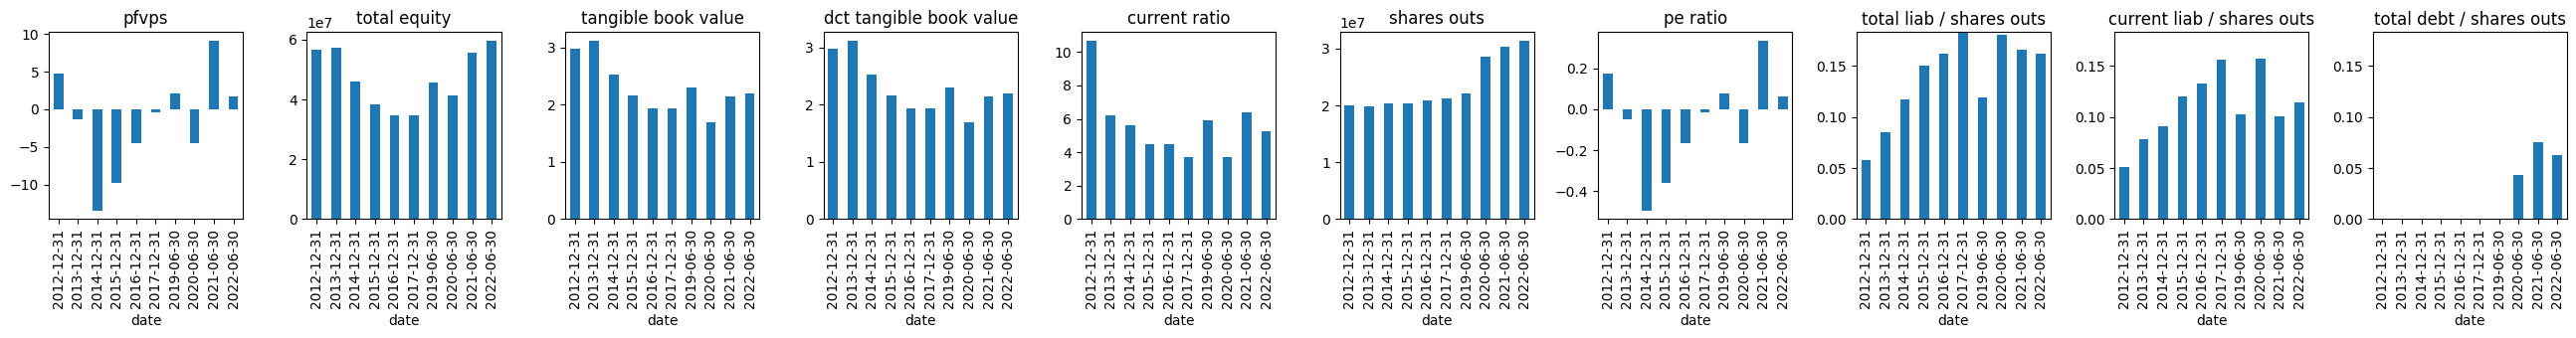

In [140]:
for ticker in ["CTHR"]:
    # define urls
    url_balance_sheet = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?limit=10&apikey={KEY}"
    url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=10&apikey={KEY}"
    try:
        # load data
        response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
        response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
    except:
        missed_tickers.append(ticker)
    data_balance_sheet = response_balance_sheet.read().decode("utf-8")
    data_balance_sheet = json.loads(data_balance_sheet)
    if len(data_balance_sheet) < 5:
        continue

    data_income_stmt = response_income_stmt.read().decode("utf-8")
    data_income_stmt = json.loads(data_income_stmt)
    if len(data_income_stmt) < 5:
        continue
        
    balance_sheet_df = pd.DataFrame(data_balance_sheet)
    income_stmt_df = pd.DataFrame(data_income_stmt)
    balance_sheet_df = balance_sheet_df.set_index("date")
    income_stmt_df = income_stmt_df.set_index("date")
    balance_sheet_df = balance_sheet_df[bs_cols]
    income_stmt_df = income_stmt_df[is_cols]

    fs_df = pd.concat([balance_sheet_df, income_stmt_df], axis=1, join="inner")
    fs_df = fs_df.iloc[::-1] # from oldest to newest
    # compute PFV
    fs_df["pfvps"] = fs_df.apply(compute_pex_value, args=(growth_value, return_value, future_pe, years,), axis=1)
    # compute tangible book value per share
    fs_df["tangible_book_value_ps"] = fs_df.apply(compute_tangible_book_value_ps, axis=1)
    # compute discounted tangible book value per share
    fs_df["dct_tangible_book_value_ps"] = fs_df.apply(compute_discounted_tangible_book_value_ps, args=(current_assets_factors, ), axis=1)
    # compute current ratio
    fs_df["current_ratio"] = fs_df.apply(compute_current_ratio, axis=1)
    # get price at report date
    fs_df["reporting_date_price"] = fs_df.apply(compute_price_at_reporting_date, axis=1)
    # compute pe ratio
    fs_df["pe_ratio"] = fs_df.apply(compute_pe_ratio, axis=1)
    # compute de ratio 1
    fs_df["de_ratio1"] = fs_df.apply(compute_de_ratio1, axis=1)
    # compute de ratio 2
    fs_df["de_ratio2"] = fs_df.apply(compute_de_ratio2, axis=1)
    # compute de ratio 3
    fs_df["de_ratio3"] = fs_df.apply(compute_de_ratio3, axis=1)

    # plot indicators
    print(ticker)
    plot_indicators(fs_df)

In [117]:
fs_df

,fillingDate,symbol,totalEquity,totalCurrentAssets,totalAssets,totalCurrentLiabilities,totalLiabilities,totalStockholdersEquity,totalDebt,goodwillAndIntangibleAssets,...,weightedAverageShsOutDil,pfvps,tangible_book_value_ps,dct_tangible_book_value_ps,current_ratio,reporting_date_price,pe_ratio,de_ratio1,de_ratio2,de_ratio3
date,,,,,,,,,,,,,,,,,,,,,
2012-12-31,2013-03-29,CTHR,56677176,30751615,59972414,2887107,3295238,56677176,0,346732,...,19967271,4.771704,2.986171,2.986171,10.651359,1.310891,0.175453,0.058140,0.050939,0.000000
2013-12-31,2014-03-27,CTHR,57427673,28042032,62323852,4500737,4896179,57427673,0,325867,...,19904170,-1.346450,3.114824,3.114824,6.230542,1.310891,-0.049508,0.085258,0.078372,0.000000
2014-12-31,2015-03-13,CTHR,46018173,23441083,51426397,4190663,5408224,46018173,0,216947,...,20295618,-13.485250,2.523178,2.523178,5.593645,1.310891,-0.495846,0.117524,0.091065,0.000000
2015-12-31,2016-03-08,CTHR,38388777,20650859,44140838,4621335,5752061,38388777,0,71086,...,20407764,-9.750873,2.159460,2.159460,4.468592,1.310891,-0.358535,0.149837,0.120382,0.000000
2016-12-31,2017-03-10,CTHR,34868621,20674188,40505776,4608256,5637155,34868621,0,8808,...,20926120,-4.564238,1.935235,1.935235,4.486337,1.310891,-0.167825,0.161668,0.132161,0.000000
2017-12-31,2018-03-09,CTHR,34858626,20149973,41230707,5446963,6372081,34858626,0,8597,...,21193793,-0.443976,1.945009,1.945009,3.699304,1.310891,-0.016325,0.182798,0.156259,0.000000
2019-06-30,2019-09-06,CTHR,45719024,27868367,51146381,4697780,5427357,45719024,0,97373,...,22111223,2.074654,2.308737,2.308737,5.932242,1.310891,0.076284,0.118711,0.102753,0.000000
2020-06-30,2020-09-04,CTHR,41435577,23909069,48904587,6486060,7469010,41435577,1790496,170151,...,28644133,-4.564238,1.701376,1.701376,3.686224,1.310891,-0.167825,0.180256,0.156534,0.043212
2021-06-30,2021-09-03,CTHR,55689016,35761231,64921999,5622263,9232983,55689016,4166925,209658,...,30232567,9.128477,2.140484,2.140484,6.360647,1.310891,0.335650,0.165795,0.100958,0.074825


In [119]:
1.659723 * 0.6

0.9958338

In [128]:
np.nanmean(compute_historical_growth(fs_df["weightedAverageShsOutDil"].values))

0.054473261882379526

TODO :

* The growth in equity is computed with growth and not with equity_growth (though it sounds stupid I just did that)
* To filter out companies from the first list I can use negative equity and price > pfv